# Extreme Heat Hazard
This notebook calculates the urban risk index for Extreme heat (EXH)
hazard.  The URI calculation has three components: expected loss, social vulnerability, and resilience capacity.  

## 1. Expected Loss
The EXH hazard expected loss (EL) includes consequences for the following receptors and marginal losses.
 * People / excess deaths
 * People / power outage hours

#### 1a. People / excess deaths
The HH&C database was used to estimate the number of heat event that occur per year in each 
borough.  This information was  downscaled to the census tract level. The median number of excess deaths due to extreme heat per year was determined to be 121 (Matte et al 2016).
The deaths were distributed evenly across the continent.  

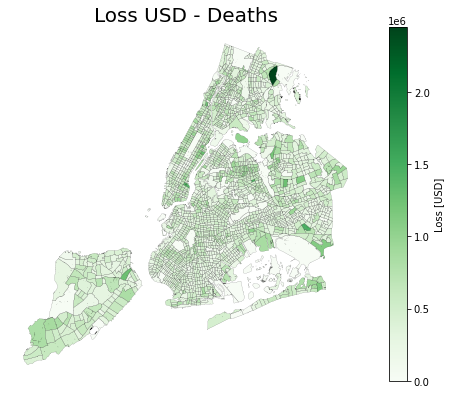

In [2]:
from MISC import params_1 as params
from MISC import utils_1 as utils
from MISC import plotting_1 as plotting
from CLASSES import class_EL_SV_CR_1 as URI
import matplotlib.pyplot as plt
import geopandas as gpd
import os
utils.set_home()
hazard_name = "EXH"


#create ESL class and add loss
path_ESL_deaths =   params.PATHNAMES.at['EXH_ESL_deaths_per_year_tract', 'Value']
gdf_ESL_deaths = gpd.read_file(path_ESL_deaths)
ESL = URI.ESL(hazard_name = hazard_name)
ESL.add_consequence("Deaths", "People", gdf_ESL_deaths)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Deaths"]["map_tract"], 'Loss USD - Deaths')

#### 1b. People / power outage hours
An analysis of the size and cause of power outages across New York City was used to estimate the average number of 
power outage hours per year (Dominianni 2018).  FEMA documents provides the loss per power outage in USD.  The hours 
were distributed evenly across the population.  

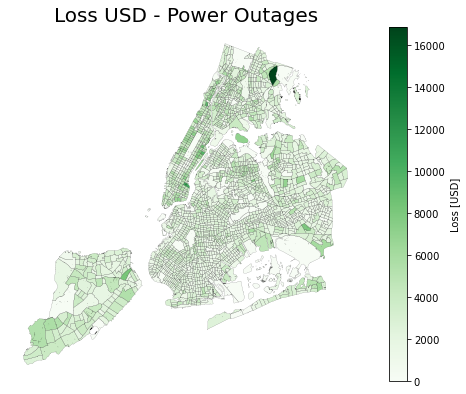

In [3]:
#all loss to ESL class
path_loss_power =   params.PATHNAMES.at['ESL_EXH_loss_power', 'Value']
gdf_ESL_power = gpd.read_file(path_loss_power)
ESL.add_consequence("Power_Outage", "People", gdf_ESL_power)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.consequence["Power_Outage"]["map_tract"], 'Loss USD - Power Outages')


#### 1b. Expected Loss Total
The total expected losses are the sum of losses from each individual consequence.  

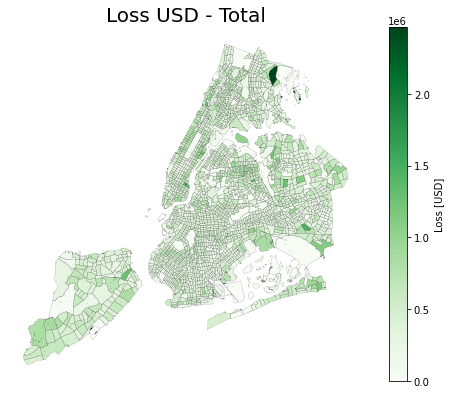

In [4]:
#total all consequences
ESL.calc_ESL_total()

#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\ESL\ESL_{}_tract.shp'.format(hazard_name, hazard_name)
ESL.ESL_map.to_file(path_save)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.ESL_map, 'Loss USD - Total')


## 2. Social Vulnerability Score
The Social Vulnerability is based on the CDC SoVI score.

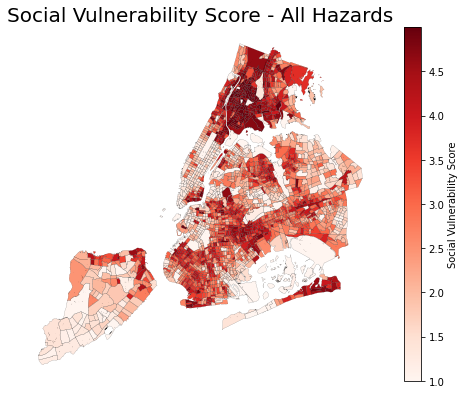

In [5]:
path_SOV = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\SOV\SOV_tract.shp'
gdf_SOV = gpd.read_file(path_SOV)
SOV = URI.SOV(hazard_name = hazard_name, map_tract = gdf_SOV)


#plot
plotting.plot_SOV_nb(SOV.SOV_map)

## 3. Resilience Capacity Score
The Resilience Capacity is the sum of four scores:
- Community capital
- Mitigation Landscape
- Response Capacity
- Recovery Resources


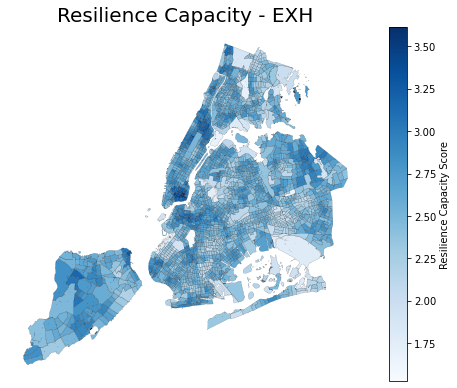

In [6]:
path_RCA = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\RCA\RCA_{}_tract.shp'.format(hazard_name)
gdf_RCA = gpd.read_file(path_RCA)
RCA = URI.RCA(hazard_name=hazard_name, map_tract=gdf_RCA)
# #plot
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111)
# RCA.RCA_map.plot(ax=ax, column = 'RCA', legend=True)
# plt.axis('off')
# plt.title('Resilience Capacity Score')

#
plotting.plot_RCA_nb('EXH', RCA.RCA_map)

## 4. Calculate URI Score
The URI is ESL * SOV / RCA.  The result is clustered into a score of 1 (low) to 5 (high).

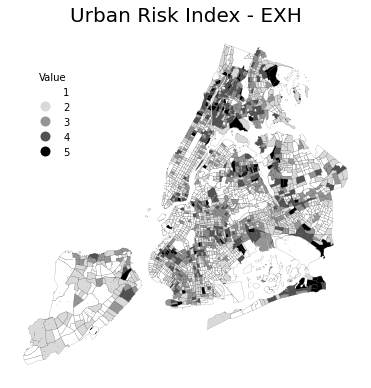

In [7]:
URI_EXH = URI.URI(hazard_name=hazard_name, ESL=ESL, SOV=SOV, RCA=RCA)
URI_EXH.calc_URI()

#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\URI\URI_{}_tract.shp'.format(hazard_name, hazard_name)
URI_EXH.URI_map.to_file(path_save)


#plot
# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111)
# URI_EXH.URI_map.plot(ax=ax, column = 'URI', legend=True)
# plt.axis('off')
# plt.title('URI Score')
plotting.plot_URI_nb(hazard_name, URI_EXH.URI_map)